## Liveness detection for Face recognition

In [1]:
# import stuff we need
import cv2
import tensorflow as tf
import keras
import numpy as np
import pathlib
import random

tf.enable_eager_execution()
tf.__version__

Using TensorFlow backend.


'1.14.0'

In [2]:
# Build dataset using tf.data
data_root = pathlib.Path('data/Detectedface/')
print(data_root)

for item in data_root.iterdir():
    print(item)
    
import random
all_image_paths = list(data_root.glob('*/*/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

data/Detectedface
data/Detectedface/imposter_test_face.txt
data/Detectedface/client_train_face.txt
data/Detectedface/.DS_Store
data/Detectedface/ClientFace
data/Detectedface/client_test_face.txt
data/Detectedface/readme.txt
data/Detectedface/imposter_train_face.txt
data/Detectedface/ImposterFace


12614

In [3]:
all_image_paths[:10]

['data/Detectedface/ImposterFace/0002/0002_01_03_02_81.jpg',
 'data/Detectedface/ImposterFace/0006/0006_00_03_03_40.jpg',
 'data/Detectedface/ImposterFace/0014/0014_01_03_03_107.jpg',
 'data/Detectedface/ImposterFace/0015/0015_01_08_03_425.jpg',
 'data/Detectedface/ClientFace/0013/0013_01_07_03_394.jpg',
 'data/Detectedface/ImposterFace/0007/0007_01_01_02_116.jpg',
 'data/Detectedface/ImposterFace/0007/0007_01_00_01_180.jpg',
 'data/Detectedface/ClientFace/0001/0001_00_00_02_224.jpg',
 'data/Detectedface/ClientFace/0009/0009_01_00_02_217.jpg',
 'data/Detectedface/ClientFace/0007/0007_01_00_02_297.jpg']

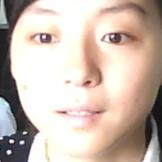

ClientFace/0006/0006_00_06_03_88.jpg



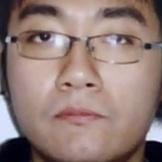

ImposterFace/0012/0012_01_03_03_68.jpg



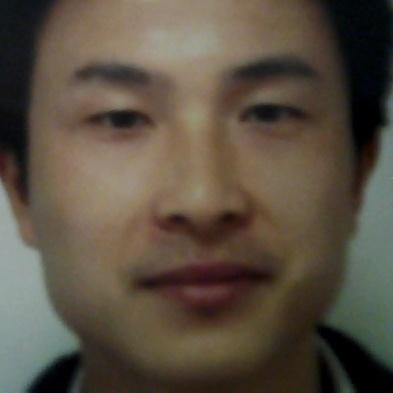

ImposterFace/0001/0001_00_04_03_235.jpg



In [4]:
import IPython.display as display

for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    print(image_rel)
    print()

In [5]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['ClientFace', 'ImposterFace']

In [6]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'ClientFace': 0, 'ImposterFace': 1}

In [7]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])
print("First 10 labels indices: ", all_image_paths[:10])

First 10 labels indices:  [1, 1, 1, 1, 0, 1, 1, 0, 0, 0]
First 10 labels indices:  ['data/Detectedface/ImposterFace/0002/0002_01_03_02_81.jpg', 'data/Detectedface/ImposterFace/0006/0006_00_03_03_40.jpg', 'data/Detectedface/ImposterFace/0014/0014_01_03_03_107.jpg', 'data/Detectedface/ImposterFace/0015/0015_01_08_03_425.jpg', 'data/Detectedface/ClientFace/0013/0013_01_07_03_394.jpg', 'data/Detectedface/ImposterFace/0007/0007_01_01_02_116.jpg', 'data/Detectedface/ImposterFace/0007/0007_01_00_01_180.jpg', 'data/Detectedface/ClientFace/0001/0001_00_00_02_224.jpg', 'data/Detectedface/ClientFace/0009/0009_01_00_02_217.jpg', 'data/Detectedface/ClientFace/0007/0007_01_00_02_297.jpg']


In [8]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range
    print(image)
    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [9]:
import matplotlib.pyplot as plt

img_path = all_image_paths[0]
label = all_image_labels[0]

with tf.Session() as sess:
    image = sess.run(load_and_preprocess_image(img_path))
plt.imshow(image)
plt.grid(False)
plt.xlabel(img_path.encode('utf-8'))
plt.title(label_names[label].title())
print()

Tensor("truediv:0", shape=(192, 192, 3), dtype=float32)



In [10]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [11]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

W0705 12:42:39.845712 4544161216 deprecation.py:323] From <ipython-input-11-2a9400bc986b>:1: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
W0705 12:42:39.847289 4544161216 deprecation.py:323] From <ipython-input-11-2a9400bc986b>:2: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [12]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Tensor("truediv:0", shape=(192, 192, 3), dtype=float32)


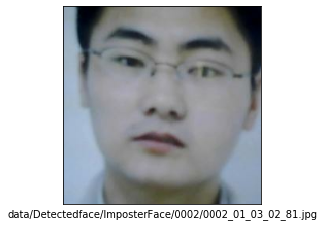

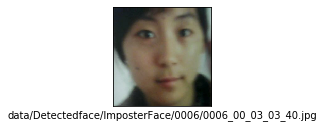

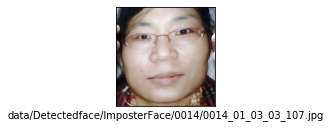

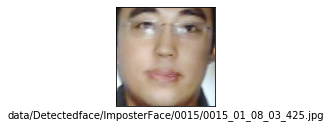

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(all_image_paths[n])
    plt.show()

In [14]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [15]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

ImposterFace
ImposterFace
ImposterFace
ImposterFace
ClientFace
ImposterFace
ImposterFace
ClientFace
ClientFace
ClientFace


In [16]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [17]:
print(image_label_ds)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [18]:
BATCH_SIZE = 128

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
train_ds = image_label_ds.take(int(0.7 * image_count))
val_ds = image_label_ds.skip(int(0.7 * image_count))
train_ds = train_ds.cache(filename='./cache.tf-data-train')
train_ds = train_ds.shuffle(buffer_size=image_count)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = val_ds.cache(filename='./cache.tf-data-val')
val_ds = val_ds.shuffle(buffer_size=image_count)
val_ds = val_ds.repeat()
val_ds = val_ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

In [19]:
#mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
#mobile_net.summary()

In [20]:
def change_range(image,label):
    return 2*image-1, label

train_ds = train_ds.map(change_range)
val_ds = val_ds.map(change_range)

In [21]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(train_ds))

In [22]:
#feature_map_batch = mobile_net(image_batch)
#print(feature_map_batch.shape)

In [23]:
'''
model = tf.keras.Sequential([
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])
'''

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3, 3), padding='same',
                 input_shape=(192, 192, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(10, (3, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(len(label_names)))
model.add(tf.keras.layers.Activation('softmax'))


In [24]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.45419058
max logit: 0.5458094

Shape: (128, 2)


In [25]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 192, 192, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 16)        2320      
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 16)        0

In [27]:
steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

99.0

In [28]:
model.fit(train_ds, epochs=5, steps_per_epoch=70, validation_data=val_ds, validation_steps=30)

Epoch 1/5


W0705 12:42:59.822404 4544161216 deprecation.py:323] From /Volumes/Data/ethan/.env_tf110_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


70/70 [==============================] - 161s 2s/step - loss: 0.4761 - acc: 0.7720 - val_loss: 0.2424 - val_acc: 0.9078
Epoch 2/5
70/70 [==============================] - 128s 2s/step - loss: 0.2000 - acc: 0.9267 - val_loss: 0.1518 - val_acc: 0.9492
Epoch 3/5
70/70 [==============================] - 128s 2s/step - loss: 0.1271 - acc: 0.9526 - val_loss: 0.1154 - val_acc: 0.9565
Epoch 4/5
70/70 [==============================] - 127s 2s/step - loss: 0.1375 - acc: 0.9516 - val_loss: 0.0965 - val_acc: 0.9646
Epoch 5/5
70/70 [==============================] - 124s 2s/step - loss: 0.1123 - acc: 0.9598 - val_loss: 0.0977 - val_acc: 0.9716
